### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 8


### Дисциплина: Методы машинного обучения

##### Студент:  Алламе Ормиз
##### Группа: НФИбд-01-21

## Москва 2024
***

### Вариант № 1

# 1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.

In [1]:
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams
import random
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
name = 'stanford_dogs'

n = 90
m = 90

values_to_keep = [1,3,5,7]

ds = tfds.load(name, split=['train[:80%]', 'train[80%:100%]', 'test'])

df_train = tfds.as_dataframe(ds[0])[['image', 'label']]
df_test = tfds.as_dataframe(ds[1])[['image', 'label']]
df_val = tfds.as_dataframe(ds[2])[['image', 'label']]

# 2. Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте по одному изображению из каждого класса, подписывая изображение меткой класса.

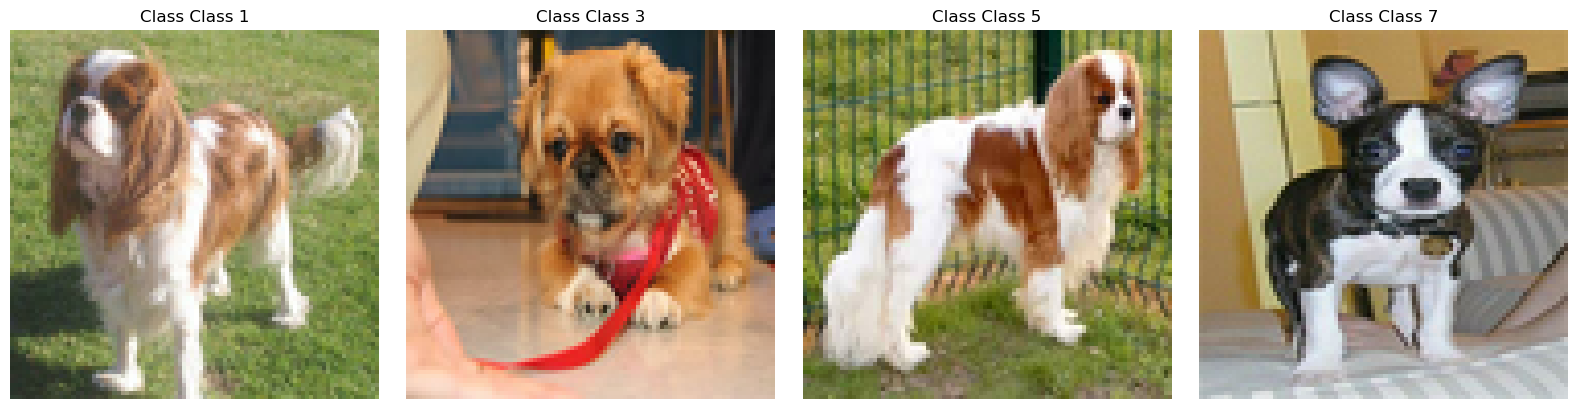

In [3]:
df_train = df_train[df_train['label'].isin(values_to_keep)]
df_val = df_val[df_val['label'].isin(values_to_keep)]
df_test = df_test[df_test['label'].isin(values_to_keep)]

train_labels = df_train['label'].to_numpy(dtype=np.float32)
val_labels = df_val['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)

n_classes = len(set(train_labels))
label_map = {value: idx for idx, value in enumerate(values_to_keep)}
train_labels = np.array([label_map[label] for label in train_labels])
val_labels = np.array([label_map[label] for label in val_labels])
test_labels = np.array([label_map[label] for label in test_labels])

train_images = np.zeros(shape=(df_train.shape[0], n, m, 3), dtype=np.float32)
val_images = np.zeros(shape=(df_val.shape[0], n, m, 3), dtype=np.float32)
test_images = np.zeros(shape=(df_test.shape[0], n, m, 3), dtype=np.float32)

def process_images(df, images_array):
    for idx in range(df.shape[0]):
        img = Image.fromarray(df.iloc[idx]['image'])
        img_resized = img.resize((n, m), Image.LANCZOS)
        img_array = np.array(img_resized)
        images_array[idx] = img_array

process_images(df_train, train_images)
process_images(df_val, val_images)
process_images(df_test, test_images)

train_images /= 255.0
val_images /= 255.0
test_images /= 255.0

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=n_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=n_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=n_classes)

def plot_sample_per_class(images, labels, class_names):
    unique_classes = np.unique(np.argmax(labels, axis=1))
    num_classes = len(unique_classes)
    
    fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))
    
    for i, class_idx in enumerate(unique_classes):
        class_images = images[np.argmax(labels, axis=1) == class_idx]
        img = class_images[0]
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Class {class_names[class_idx]}')
    
    plt.tight_layout()
    plt.show()

class_names = [f'Class {i}' for i in values_to_keep]
plot_sample_per_class(train_images, train_labels, class_names)

# 3. Постройте нейронные сети различных архитектур (MLP, CNN, RNN, трансформер) для задачи многоклассовой классификации изображений (архитектуры и требования к сетям указаны в индивидуальном задании), используя функции потерь, указанные в индивидуальном задании. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Обучайте нейронные сети с использованием валидационной выборки, сформированной в п. 1. Останавливайте переобучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд.

In [4]:
epoch = 10

In [5]:
train_labels_sparse = tf.argmax(train_labels, axis=1)
val_labels_sparse = tf.argmax(val_labels, axis=1)

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization

model_1 = Sequential([
    Input(shape=(n, m, 3)),
    Flatten(),
    Dense(80, activation='selu'),
    BatchNormalization()
])

neurons = 80
for i in range(3):
    neurons -= 10
    model_1.add(Dense(neurons, activation='selu'))
    model_1.add(BatchNormalization())

model_1.add(Dense(len(values_to_keep), activation='softmax'))

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_images,
    train_labels, 
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels), 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/10
3/3 [==============================] - 6s 304ms/step - loss: 2.0636 - accuracy: 0.2492 - val_loss: 2.1401 - val_accuracy: 0.2993
Epoch 2/10
3/3 [==============================] - 0s 53ms/step - loss: 1.0694 - accuracy: 0.5710 - val_loss: 2.5810 - val_accuracy: 0.2211
Epoch 3/10
3/3 [==============================] - 0s 47ms/step - loss: 0.9444 - accuracy: 0.6435 - val_loss: 2.9830 - val_accuracy: 0.2007
Epoch 4/10
3/3 [==============================] - 0s 54ms/step - loss: 0.8840 - accuracy: 0.6719 - val_loss: 3.1024 - val_accuracy: 0.2041
Epoch 5/10
3/3 [==============================] - 0s 47ms/step - loss: 0.8243 - accuracy: 0.7161 - val_loss: 3.0409 - val_accuracy: 0.2007
Epoch 6/10
3/3 [==============================] - 0s 49ms/step - loss: 0.7650 - accuracy: 0.7382 - val_loss: 2.8636 - val_accuracy: 0.2007
Epoch 7/10
3/3 [==============================] - 0s 47ms/step - loss: 0.6943 - accuracy: 0.7729 - val_loss: 2.6768 - val_accuracy: 0.2075
Epoch 8/10
3/3 [==========

In [7]:
inputs = tf.keras.layers.Input(shape=(n, m, 3))

conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(inputs)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(pool2)
pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

flatten = tf.keras.layers.Flatten()(pool3)

dense1 = tf.keras.layers.Dense(90, activation='selu')(flatten)
dense2 = tf.keras.layers.Dense(60, activation='selu')(dense1)
dropout = tf.keras.layers.Dropout(0.3)(dense2)

outputs = tf.keras.layers.Dense(len(values_to_keep), activation='softmax')(dropout)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_images,
    train_labels,
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/10
3/3 [==============================] - 3s 410ms/step - loss: 5.7703 - accuracy: 0.2587 - val_loss: 5.4962 - val_accuracy: 0.2449
Epoch 2/10
3/3 [==============================] - 1s 211ms/step - loss: 5.4065 - accuracy: 0.2650 - val_loss: 5.2751 - val_accuracy: 0.2891
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 5.2495 - accuracy: 0.2902 - val_loss: 5.1676 - val_accuracy: 0.2959
Epoch 4/10
3/3 [==============================] - 1s 208ms/step - loss: 5.1331 - accuracy: 0.2744 - val_loss: 5.0295 - val_accuracy: 0.3231
Epoch 5/10
3/3 [==============================] - 1s 228ms/step - loss: 4.9795 - accuracy: 0.3502 - val_loss: 4.9068 - val_accuracy: 0.3707
Epoch 6/10
3/3 [==============================] - 1s 220ms/step - loss: 4.8561 - accuracy: 0.3817 - val_loss: 4.8006 - val_accuracy: 0.3401
Epoch 7/10
3/3 [==============================] - 1s 227ms/step - loss: 4.7712 - accuracy: 0.3502 - val_loss: 4.6995 - val_accuracy: 0.3367
Epoch 8/10
3/3 [====

In [8]:
import tensorflow as tf

train_labels_sparse = tf.argmax(train_labels, axis=1)
val_labels_sparse = tf.argmax(val_labels, axis=1)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Input(shape=(n, m, 3)))
model_3.add(tf.keras.layers.Flatten())

for i in range(6):
    if i % 2 == 0:
        model_3.add(tf.keras.layers.Dense(90, activation='selu'))
    else:
        model_3.add(tf.keras.layers.Dense(60, activation='selu'))
        model_3.add(tf.keras.layers.Dropout(0.3))

model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Reshape((6, 10)))
model_3.add(tf.keras.layers.LSTM(64))
model_3.add(tf.keras.layers.Dense(len(values_to_keep), activation='softmax'))

model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_images,
    train_labels,
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/10
3/3 [==============================] - 7s 594ms/step - loss: 1.3928 - accuracy: 0.2587 - val_loss: 1.4073 - val_accuracy: 0.2415
Epoch 2/10
3/3 [==============================] - 0s 68ms/step - loss: 1.3889 - accuracy: 0.3028 - val_loss: 1.3920 - val_accuracy: 0.2381
Epoch 3/10
3/3 [==============================] - 0s 73ms/step - loss: 1.3857 - accuracy: 0.2681 - val_loss: 1.3818 - val_accuracy: 0.2313
Epoch 4/10
3/3 [==============================] - 0s 55ms/step - loss: 1.3895 - accuracy: 0.2587 - val_loss: 1.3778 - val_accuracy: 0.2449
Epoch 5/10
3/3 [==============================] - 0s 65ms/step - loss: 1.3902 - accuracy: 0.2524 - val_loss: 1.3755 - val_accuracy: 0.2687
Epoch 6/10
3/3 [==============================] - 0s 60ms/step - loss: 1.3970 - accuracy: 0.2492 - val_loss: 1.3750 - val_accuracy: 0.2857
Epoch 7/10
3/3 [==============================] - 0s 67ms/step - loss: 1.3827 - accuracy: 0.2808 - val_loss: 1.3746 - val_accuracy: 0.2891
Epoch 8/10
3/3 [==========

# 4. Вычислите и выведите в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) для обучающей и тестовой выборок.

10/10 [==============================] - 0s 3ms/step


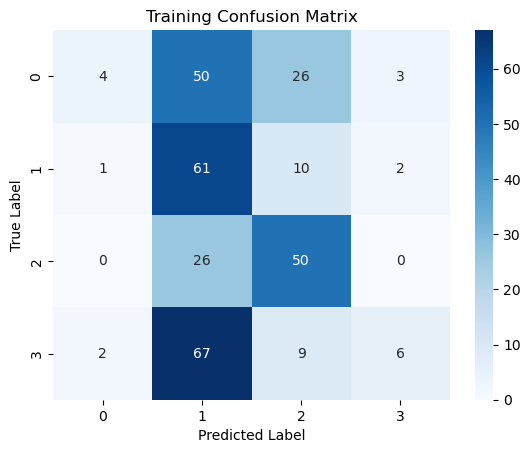

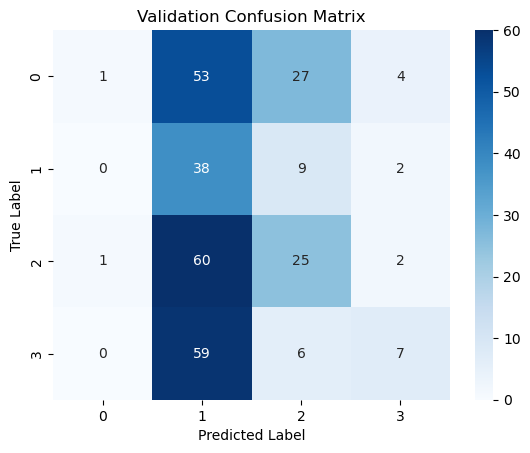

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def compute_and_plot_confusion_matrix(model, train_images, train_labels, val_images, val_labels, is_sparse):
    train_predictions = np.argmax(model.predict(train_images), axis=1)
    val_predictions = np.argmax(model.predict(val_images), axis=1)
    
    if not is_sparse:
        train_labels_sparse = np.argmax(train_labels, axis=1)
        val_labels_sparse = np.argmax(val_labels, axis=1)
    else:
        train_labels_sparse = train_labels
        val_labels_sparse = val_labels

    train_cm = tf.math.confusion_matrix(train_labels_sparse, train_predictions)
    val_cm = tf.math.confusion_matrix(val_labels_sparse, val_predictions)

    plot_confusion_matrix(train_cm, labels=range(len(values_to_keep)), title='Training Confusion Matrix')
    plot_confusion_matrix(val_cm, labels=range(len(values_to_keep)), title='Validation Confusion Matrix')

compute_and_plot_confusion_matrix(model_1, train_images, train_labels_sparse, val_images, val_labels_sparse, is_sparse=True)

10/10 [==============================] - 0s 17ms/step


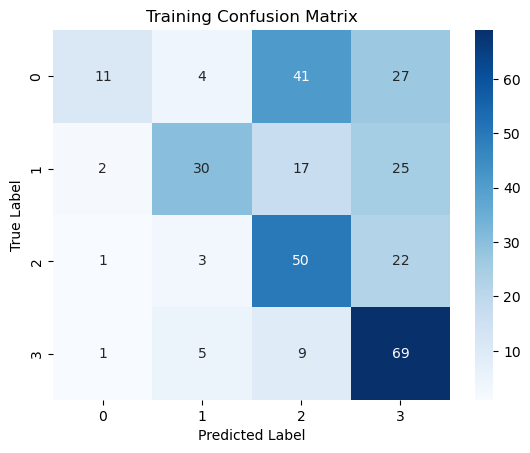

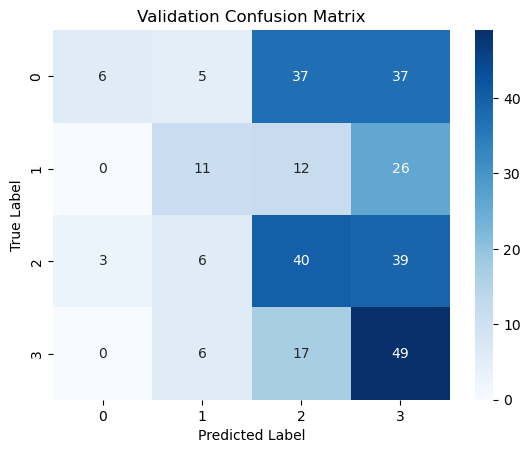

In [10]:
compute_and_plot_confusion_matrix(model_2, train_images, train_labels, val_images, val_labels, is_sparse=False)

10/10 [==============================] - 0s 4ms/step


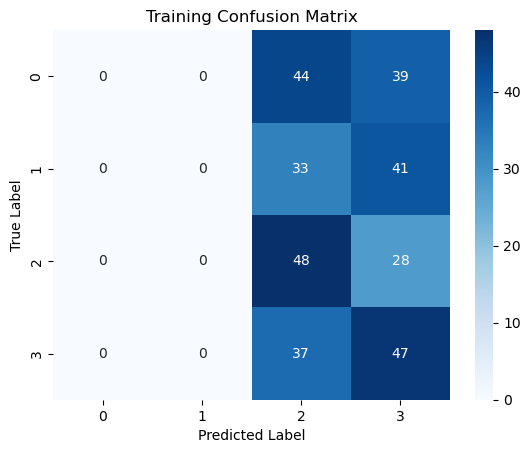

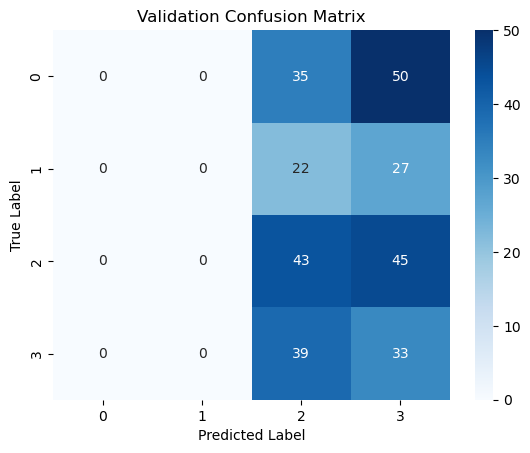

In [11]:
compute_and_plot_confusion_matrix(model_3, train_images, train_labels, val_images, val_labels, is_sparse=False)

# 5. Визуализируйте кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).


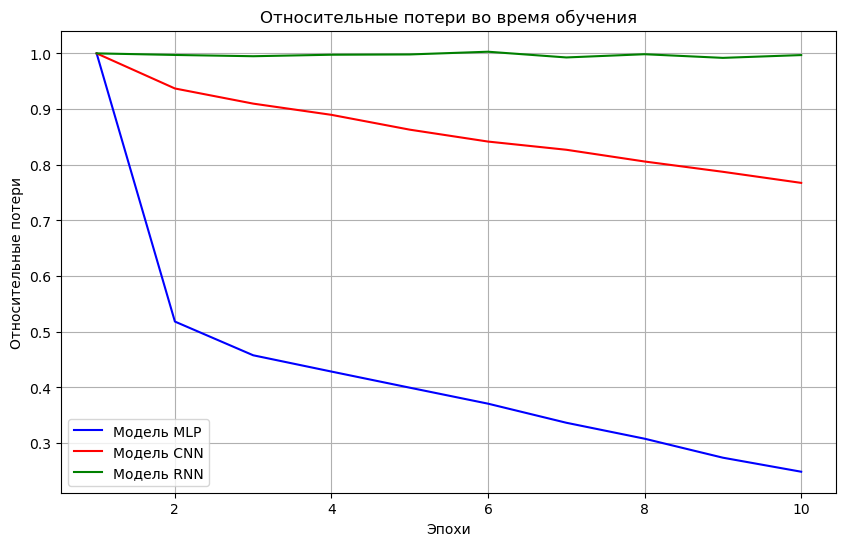

In [12]:
import matplotlib.pyplot as plt
import numpy as np

initial_loss_1 = history_1.history['loss'][0]
initial_loss_2 = history_2.history['loss'][0]
initial_loss_3 = history_3.history['loss'][0]

relative_losses_1 = np.array(history_1.history['loss']) / initial_loss_1
relative_losses_2 = np.array(history_2.history['loss']) / initial_loss_2
relative_losses_3 = np.array(history_3.history['loss']) / initial_loss_3

num_epochs = max(len(relative_losses_1), len(relative_losses_2), len(relative_losses_3))
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(relative_losses_1)], relative_losses_1, 'b-', label='Модель MLP')
plt.plot(epochs[:len(relative_losses_2)], relative_losses_2, 'r-', label='Модель CNN')
plt.plot(epochs[:len(relative_losses_3)], relative_losses_3, 'g-', label='Модель RNN')

plt.title('Относительные потери во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Относительные потери')
plt.legend()
plt.grid(True)
plt.show()

# 6. Оцените качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите название нейронной сети с лучшим качеством.

In [13]:
# Средняя точность
from sklearn.metrics import precision_score

test_labels_flat = np.argmax(test_labels, axis=1)

mlp_test_probabilities = model_1.predict(test_images)
mlp_test_predictions = np.argmax(mlp_test_probabilities, axis=1)
mlp_test_precision = precision_score(test_labels_flat, mlp_test_predictions, average=None)

cnn_test_probabilities = model_2.predict(test_images)
cnn_test_predictions = np.argmax(cnn_test_probabilities, axis=1)
cnn_test_precision = precision_score(test_labels_flat, cnn_test_predictions, average=None)

rnn_test_probabilities = model_3.predict(test_images)
rnn_test_predictions = np.argmax(rnn_test_probabilities, axis=1)
rnn_test_precision = precision_score(test_labels_flat, rnn_test_predictions, average=None)

best_1 = np.mean(mlp_test_precision)
best_2 = np.mean(cnn_test_precision)
best_3 = np.mean(rnn_test_precision)

best = max(best_1,best_2,best_3)

if best == best_1:
    best_model = "MLP"
    print("Модель MLP - наиболее эффективная")
elif best == best_2:
    best_model = "CNN"
    print("Модель CNN - наиболее эффективная")
else:
    best_model = "RNN"
    print("Модель RNN - наиболее эффективная")

print("Архитектура наиболее эффективной модели:")
if best_model == "MLP":
    model_1.summary()
elif best_model == "CNN":
    model_2.summary()
else:
    model_3.summary()

3/3 [==============================] - 0s 9ms/step
Модель CNN - наиболее эффективная
Архитектура наиболее эффективной модели:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
 